# Prepare DF

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path

'/home/tjanicek/thesis/thoth-issue-predictor'

In [2]:
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from catboost import Pool, CatBoostClassifier
from datetime import datetime
from thoth_issue_predictor.evaluation.metrics import Metrics
from thoth_issue_predictor.evaluation.model_evaluation import ModelEvaluation
from thoth_issue_predictor.preprocessing.grid_search import (
    grid_search_scikit,
    grid_search_catboost,
)

from thoth_issue_predictor.utils.preprocessing import (
    prepare_df,
)

In [3]:
inspections_df = prepare_df()
exit_codes = inspections_df["exit_code"]

KeyboardInterrupt: 

In [ ]:
from typing import Any, Dict, List, Tuple

import pandas as pd
from parver import Version


def create_df(
    inspections_df: pd.DataFrame,
) -> Tuple[pd.DataFrame, List[str]]:
    """Create DF for predicting build/runtime issues."""
    python_packages_versions: Dict[str, Any] = {}
    python_packages_names = []
    python_indexes = ["unknown"]

    sws_df = inspections_df[
        [col for col in inspections_df.columns.values if "__index" in col]
    ]

    for c_name in sws_df.columns.values:
        if "__index" in c_name:
            python_packages_names.append(c_name.split("__")[2])

    columns_packages = ["requirements_locked___meta__requires__python_version"]
    for package in python_packages_names:
        columns_packages.append(
            "".join(["requirements_locked__default__", package, "__index"])
        )
        columns_packages.append(
            "".join(["requirements_locked__default__", package, "__version"])
        )

    python_packages_versions["python"] = []
    for _, row in inspections_df[columns_packages].iterrows():
        python_version = row["requirements_locked___meta__requires__python_version"]

        if pd.isnull(python_version):
            python_packages_versions["python"].append(0)
        else:
            python_packages_versions["python"].append(
                int(python_version.replace(".", ""))
            )

        for package in python_packages_names:
            version = row[
                "".join(["requirements_locked__default__", package, "__version"])
            ]

            index = row["".join(["requirements_locked__default__", package, "__index"])]

            if not pd.isnull(index) and (index not in python_indexes):
                python_indexes.append(index)

            if pd.isnull(version):
                if f"{package}_major" not in python_packages_versions.keys():
                    python_packages_versions[f"{package}_major"] = []
                    python_packages_versions[f"{package}_minor"] = []
                    python_packages_versions[f"{package}_micro"] = []
                    python_packages_versions[f"{package}_index"] = []

                python_packages_versions[f"{package}_major"].append(0)
                python_packages_versions[f"{package}_minor"].append(0)
                python_packages_versions[f"{package}_micro"].append(0)
                python_packages_versions[f"{package}_index"].append(0)

            else:
                if f"{package}_major" not in python_packages_versions.keys():
                    python_packages_versions[f"{package}_major"] = []
                    python_packages_versions[f"{package}_minor"] = []
                    python_packages_versions[f"{package}_micro"] = []
                    python_packages_versions[f"{package}_index"] = []

                try:
                    package_version = Version.parse(
                        version.replace("==", "")
                    ).normalize()
                except ValueError:
                    package_version = Version.parse("0.0.0")

                python_packages_versions[f"{package}_major"].append(
                    package_version.release[0]
                    if len(package_version.release) > 0
                    else 0
                )
                python_packages_versions[f"{package}_minor"].append(
                    package_version.release[1]
                    if len(package_version.release) > 1
                    else 0
                )
                python_packages_versions[f"{package}_micro"].append(
                    package_version.release[2]
                    if len(package_version.release) > 2
                    else 0
                )
                python_packages_versions[f"{package}_index"].append(
                    python_indexes.index(index)
                )

    return (
        pd.DataFrame(python_packages_versions),
        python_indexes,
    )

In [4]:
(
    issues_df,
    python_indexes,
) = create_df(inspections_df=inspections_df)

In [ ]:
issues_df["exit_code"] = exit_codes.astype("int")
issues_df = issues_df.loc[
    (issues_df.loc[:, issues_df.columns != "exit_code"] != 0).any(axis=1)
]
issues_df = issues_df.drop_duplicates()

In [5]:
python_indexes

['unknown', 'pypi-org-simple', 'pypi-org', 'aicoe', 'pypi']

In [6]:
print(f"Length of DF is {len(issues_df)}")
issues_df.head(5)

Length of DF is 1947


,python,tensorflow_major,tensorflow_minor,tensorflow_patch,tensorflow_index,flatbuffers_major,flatbuffers_minor,flatbuffers_patch,flatbuffers_index,six_major,...,pyyaml_index,torch_major,torch_minor,torch_patch,torch_index,tensorflow-cpu_major,tensorflow-cpu_minor,tensorflow-cpu_patch,tensorflow-cpu_index,exit_code
0,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,38,2,4,1,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,38,2,4,0,1,1,12,0,1,1,...,0,0,0,0,0,0,0,0,0,0


# Failed inspections

In [7]:
failed_inspections = issues_df[issues_df["exit_code"] == 1]
print(f"Number of failed inspections: {len(failed_inspections)}")
failed_inspections.head()

Number of failed inspections: 102


,python,tensorflow_major,tensorflow_minor,tensorflow_patch,tensorflow_index,flatbuffers_major,flatbuffers_minor,flatbuffers_patch,flatbuffers_index,six_major,...,pyyaml_index,torch_major,torch_minor,torch_patch,torch_index,tensorflow-cpu_major,tensorflow-cpu_minor,tensorflow-cpu_patch,tensorflow-cpu_index,exit_code
1896,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1897,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1898,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1899,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1900,36,2,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


# Decision Trees

In [8]:
issue_x, exit_codes = issues_df.drop("exit_code", axis=1), issues_df["exit_code"]

X_train, X_test, y_train, y_test = train_test_split(
    issue_x, exit_codes, test_size=0.4, random_state=0
)

## Scikit CART model

In [9]:
best_params = grid_search_scikit(X_train, y_train)
best_params

{'ccp_alpha': 0.2,
 'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 10,
 'splitter': 'best'}

In [10]:
clf = DecisionTreeClassifier(**best_params)

start = datetime.now()
clf.fit(X_train, y_train)
end = datetime.now()

pred = clf.predict(X_test)

In [11]:
feature_names = issue_x.columns
target_names = ["successful", "failed"]
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=feature_names,
    class_names=target_names,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph.render("trees/ThothIssuePredictor", format="pdf")

'trees/ThothIssuePredictor.pdf'

Train time: 0:00:00.007792
Number of errors: 39
AUC: 0.5
Accuracy Score: 0.9499358151476252
F1 weighted: 0.9255464163387
F1 micro: 0.9499358151476252
F1 macro: 0.4871626069782752
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       740
           1       0.00      0.00      0.00        39

    accuracy                           0.95       779
   macro avg       0.47      0.50      0.49       779
weighted avg       0.90      0.95      0.93       779

Confusion matrix for scikit
[[740   0]
 [ 39   0]]


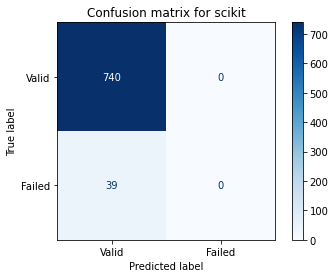

In [12]:
scikit_evaluation = ModelEvaluation("scikit", clf, end - start, X_test, y_test)
scikit_evaluation.predict_and_save()
scikit_evaluation.print()

## CatBoost GBDT model

In [13]:
cat_features = [f for f in feature_names if "_index" in f]

issue_pool = Pool(issue_x, exit_codes, cat_features=cat_features)
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [ ]:
best_params = grid_search_catboost(train_pool)


bestTest = 0.995734127
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9953373016
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9956349206
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.995734127
bestIteration = 19

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9953373016
bestIteration = 23

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.9956349206
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate

In [ ]:
clf = CatBoostClassifier(use_best_model=True, **best_params)
best_params

In [ ]:
clf.tree_count_

In [ ]:
start = datetime.now()
clf.fit(train_pool, eval_set=test_pool)
end = datetime.now()

pred = clf.predict(test_pool)

In [ ]:
dot_data = clf.plot_tree(1, pool=train_pool)
graph = graphviz.Source(dot_data)
graph.render("trees/ThothIssuePredictorBoost", format="pdf")

In [ ]:
catboost_evaluation = ModelEvaluation("catboost", clf, end - start, X_train, y_train)
catboost_evaluation.predict_and_save()
catboost_evaluation.print()

## Comparison

In [ ]:
metrics = Metrics([scikit_evaluation, catboost_evaluation])

metrics.sort_metrics()
print("--------------------------------------------")
print("Results for each category from best to worst")
print("--------------------------------------------")
metrics.print_results()

print("-----------------------------")
print("Best models for each category")
print("-----------------------------")
metrics.print_results()